# ZFNet

Source: https://towardsdatascience.com/zfnet-an-explanation-of-paper-with-code-f1bd6752121d

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import imageio as iio
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from PIL import Image
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
import keras
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import csv
import re
from datetime import datetime
import collections
from readInImages import readInImages
from readInAnnotations import readInAnnotations

In [2]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure()
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

In [3]:
# free up GPU if it didn't after the last run
cuda.select_device(0)
cuda.close()

## Read in dataset

* first argument is the `using_batch_generator` flag
* second argument is `do_preprocessing`, which will perform image manipulations for the purposes of enhancing training performance
* all other arguments are the datasets - e.g., a folder ('20160724_July') with additional folders ('BB01', 'BB02', ..., 'BBXY'), each containing a set of images)

In [4]:
# %run readInDataset.py true false 20160724_July 20160829_August
%run readInDataset.py true false 20160724_July

args: ['readInDataset.py', 'true', 'false', '20160724_July']
using_batch_generator? True
doing pre-processing? False
dataset_names: ['20160724_July']
reading in images and labels for dataset: 20160724_July
all_folders_for_curr_dataset: ['BB01', 'BB02', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11', 'BB12', 'BB13', 'BB14', 'BB15', 'BB16', 'BB17', 'BB18', 'BB19', 'BB20', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25', 'BB26', 'BB27', 'BB28', 'BB29', 'BB30', 'BB31', 'BB32', 'BB33', 'BB34', 'BB35', 'BB36']
reading in labels for subset: BB01
returning labelList of length: 285
reading in images for subset: BB01
all_image_filenames length: 285
done current subset
reading in labels for subset: BB02
returning labelList of length: 45
reading in images for subset: BB02
all_image_filenames length: 45
done current subset
reading in labels for subset: BB03
returning labelList of length: 230
reading in images for subset: BB03
all_image_filenames length: 230
done current subset
readin

In [5]:
class CustomGenerator(keras.utils.Sequence):    
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return batch_x, np.array(batch_y)

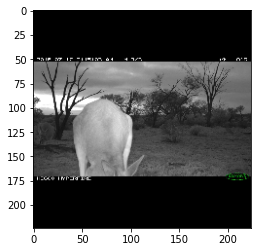

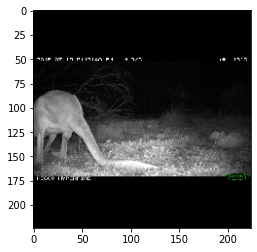

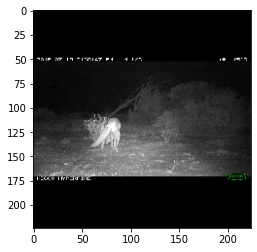

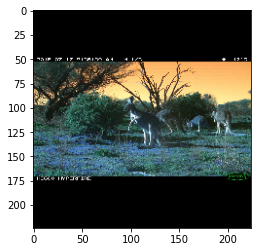

In [6]:
batch_size = 128

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

# show a few samples
displayImage(training_images[0])
displayImage(training_images[10])
displayImage(training_images[100])
displayImage(training_images[1000])

training_batch_generator = CustomGenerator(training_images, training_labels, batch_size)
validation_batch_generator = CustomGenerator(valid_images, valid_labels, batch_size)

## Train the model

In [7]:
model = tf.keras.models.Sequential([                                    
    tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), \
              loss='categorical_crossentropy', \
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \
    factor=0.1, patience=1, \
    min_lr=0.00001)

model.fit(training_batch_generator,
          validation_data=validation_batch_generator,
          epochs=5,
          callbacks=[reduce_lr])

Epoch 1/5


2022-06-14 07:55:59.499826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 07:55:59.503057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 07:55:59.503289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 07:55:59.503827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

35/35 [==============================] - 11s 222ms/step - loss: 1.8605 - accuracy: 0.4843 - top_k_categorical_accuracy: 0.9229 - val_loss: 1.2469 - val_accuracy: 0.5961 - val_top_k_categorical_accuracy: 0.9786 - lr: 0.0100
Epoch 2/5
35/35 [==============================] - 6s 158ms/step - loss: 1.1123 - accuracy: 0.6098 - top_k_categorical_accuracy: 0.9873 - val_loss: 1.0648 - val_accuracy: 0.6157 - val_top_k_categorical_accuracy: 0.9937 - lr: 0.0100
Epoch 3/5
35/35 [==============================] - 6s 158ms/step - loss: 1.0560 - accuracy: 0.6102 - top_k_categorical_accuracy: 0.9915 - val_loss: 1.0034 - val_accuracy: 0.6184 - val_top_k_categorical_accuracy: 0.9937 - lr: 0.0100
Epoch 4/5
35/35 [==============================] - 6s 158ms/step - loss: 0.9846 - accuracy: 0.6270 - top_k_categorical_accuracy: 0.9904 - val_loss: 0.9596 - val_accuracy: 0.6443 - val_top_k_categorical_accuracy: 0.9929 - lr: 0.0100
Epoch 5/5
35/35 [==============================] - 6s 158ms/step - loss: 0.9560 -

## Use test set to assess trained model's performance

### Evaluate

In [8]:
print('test_images shape: {}'.format(test_images.shape))
print('test_labels shape: {}'.format(test_labels.shape))

results = model.evaluate(test_images,test_labels)
print('loss: {}'.format(results[0]))
print('accuracy: {}'.format(results[1]))
print('top_k_categorical_accuracy: {}'.format(results[2]))

test_images shape: (1398, 224, 224, 3)
test_labels shape: (1398, 10)
44/44 [==============================] - 1s 18ms/step - loss: 0.9524 - accuracy: 0.6309 - top_k_categorical_accuracy: 0.9886
loss: 0.9523770213127136
accuracy: 0.6309012770652771
top_k_categorical_accuracy: 0.9885550737380981


### Predict and print classification report

In [9]:
predictions = (model.predict(test_images) > 0.5).astype("int32")

44/44 [==============================] - 1s 13ms/step


In [10]:
print("test_classes: {}".format(test_classes))
print("train classes count: {}".format(counter_test))
# classification_report uses alphabetic ordering of the classes, so to match the encoded labels to the target_names, provide a sortest list of classes
# https://stackoverflow.com/a/48495303
sorted_test_classes = sorted(test_classes)
print('sorted_test_classes: {}'.format(sorted_test_classes))
# print(classification_report(test_labels, predictions, target_names=sorted_test_classes))
print(classification_report(test_labels, predictions))

test_classes: ['Empty photo', 'Kangaroo', 'Emu', 'Human Presense/Deployment', 'Cat', 'Fox', 'Bird', 'Dog', 'Other', 'Rabbit']
train classes count: Counter({'Kangaroo': 814, 'Empty photo': 299, 'Emu': 127, 'Human Presense/Deployment': 95, 'Fox': 27, 'Cat': 17, 'Bird': 8, 'Rabbit': 8, 'Other': 2, 'Dog': 1})
sorted_test_classes: ['Bird', 'Cat', 'Dog', 'Empty photo', 'Emu', 'Fox', 'Human Presense/Deployment', 'Kangaroo', 'Other', 'Rabbit']
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00         1
           3       0.73      0.23      0.35       299
           4       0.00      0.00      0.00       127
           5       0.00      0.00      0.00        27
           6       0.00      0.00      0.00        95
           7       0.76      0.78      0.77       814
           8       0.00      0.00      0.00         2
           9       

/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion matrix

In [11]:
matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
print(matrix)

[[  5   0   0   0   0   0   0   3   0   0]
 [  7   0   0   1   0   0   0   9   0   0]
 [  1   0   0   0   0   0   0   0   0   0]
 [104   0   0  68   0   0   0 127   0   0]
 [106   0   0   0   0   0   0  21   0   0]
 [  7   0   0   1   0   0   0  19   0   0]
 [ 71   0   0   0   1   0   0  23   0   0]
 [158   0   0  21   0   0   0 635   0   0]
 [  0   0   0   1   0   0   0   1   0   0]
 [  4   0   0   1   0   0   0   3   0   0]]


### Accuracy

In [12]:
acc = accuracy_score(test_labels, predictions)
print(acc)

0.5028612303290415


## Use a distinct dataset to assess trained model's performance
* still camera trap images from same location(s), but subset was not used for training, validation, or testing
* note: images are not pre-processed, and are simply loaded in and resized
* TODO: use Australian camera trap images from different location(s) to assess performance

folders_dataset: ['images']
folders_dataset: ['images']
reading in images for subset: images
all_image_filenames length: 18
unlabelled_test_images shape[0]: (224, 224, 3)
stacked unlabelled_test_images shape: (18, 224, 224, 3)


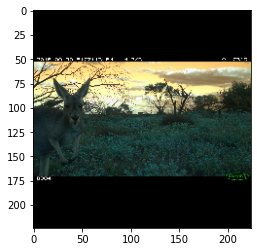

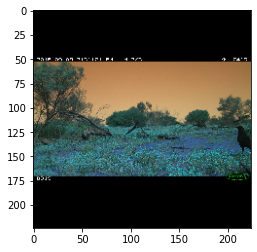

In [13]:
unlabelled_test_images = []
folders_dataset = next(os.walk('data/unlabelled_test_data'))[1]
print('folders_dataset: {}'.format(folders_dataset))
folders_dataset = sorted(folders_dataset)
print('folders_dataset: {}'.format(folders_dataset))
for folder in folders_dataset:
    unlabelled_test_images = [*unlabelled_test_images, *readInImages('unlabelled_test_data', folder, False)]

print('unlabelled_test_images shape[0]: {}'.format(unlabelled_test_images[0].shape))
    
displayImage(unlabelled_test_images[1])
displayImage(unlabelled_test_images[10])
# displayImage(unlabelled_test_images[100])
# displayImage(unlabelled_test_images[1000])

unlabelled_test_images = np.stack(unlabelled_test_images, axis = 0)
print('stacked unlabelled_test_images shape: {}'.format(unlabelled_test_images.shape))

### Predict

In [14]:
class_mappings = ['Bird', 'Cat', 'Dog', 'Empty photo', 'Emu', 'Fox', 'Humman Presense/Deployment', 'Kangaroo', 'Other', 'Rabbit']

1/1 [==============================] - 0s 154ms/step


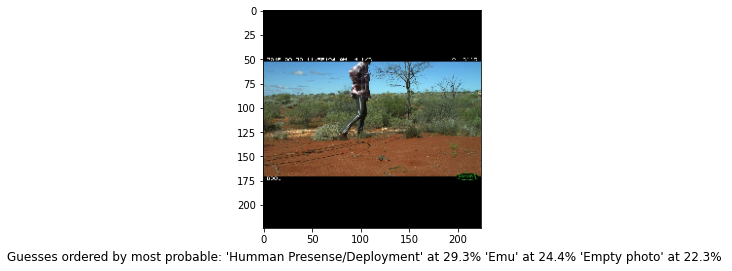

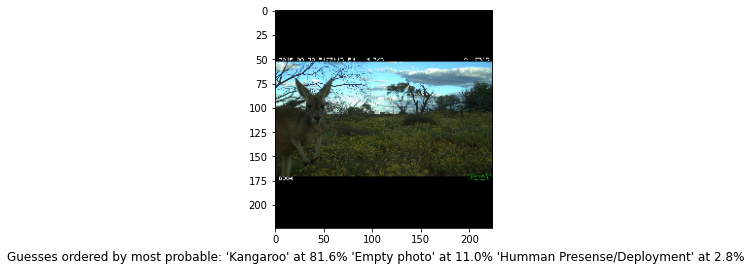

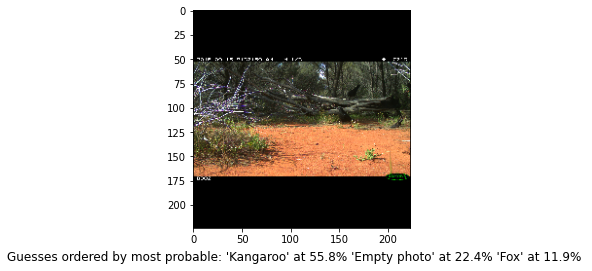

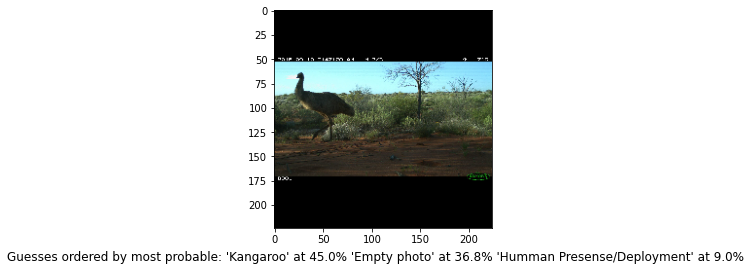

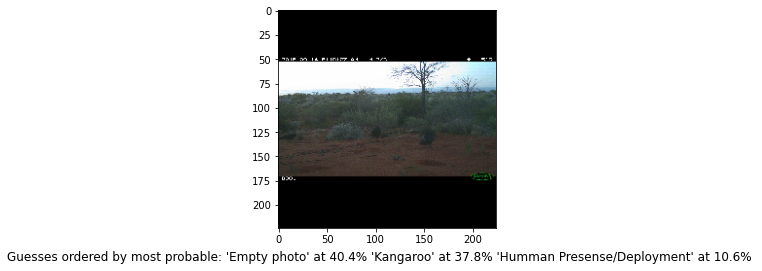

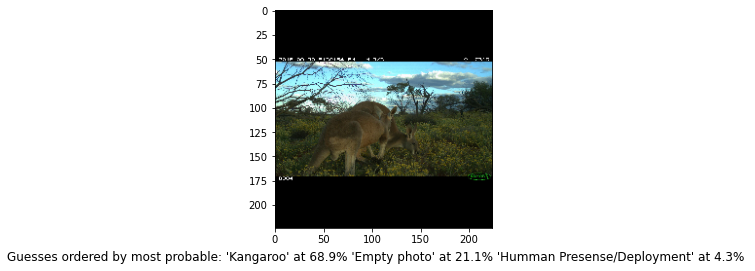

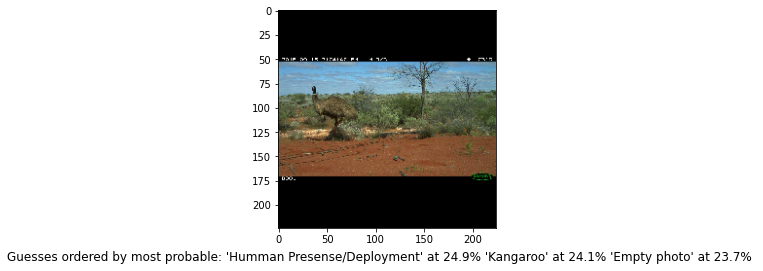

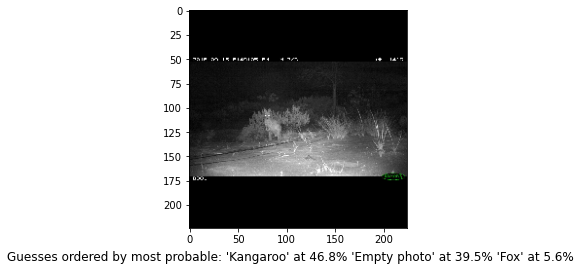

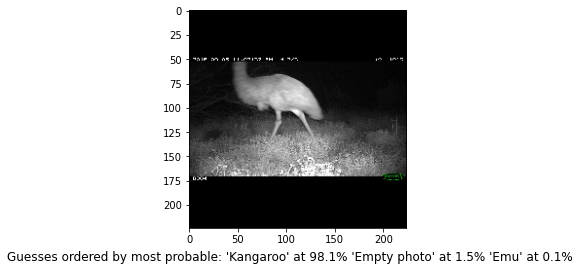

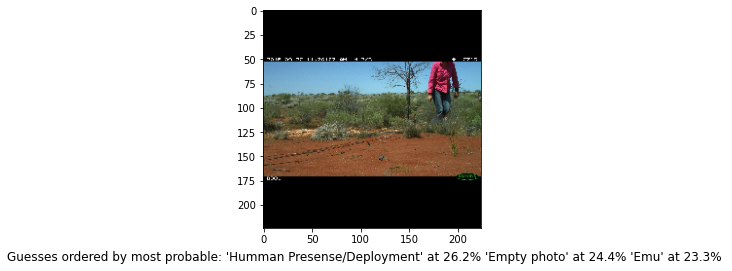

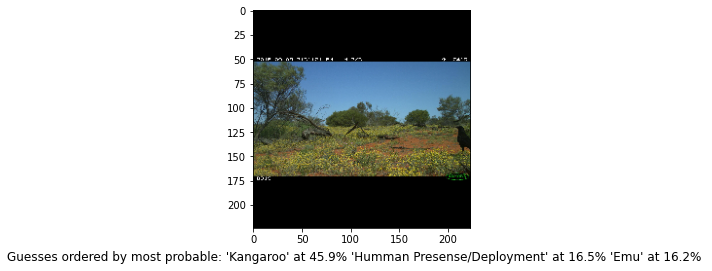

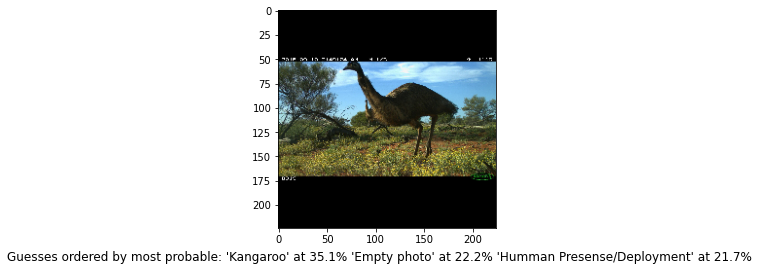

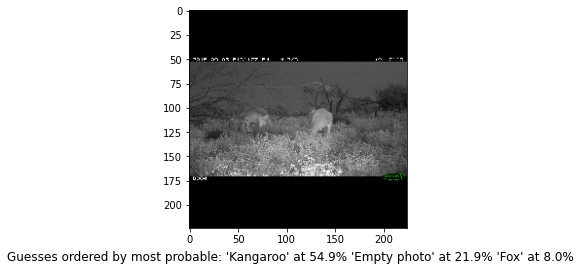

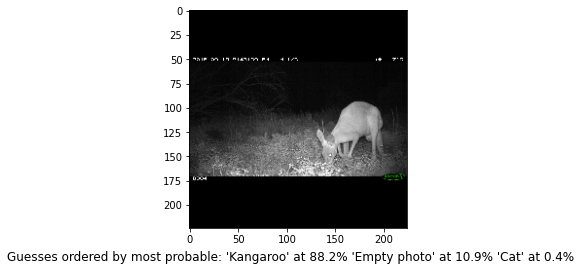

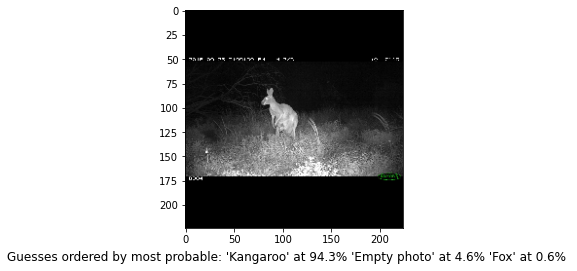

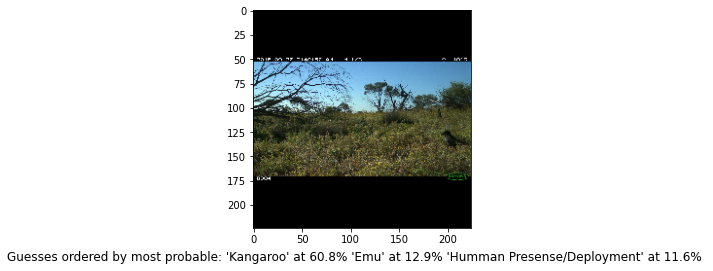

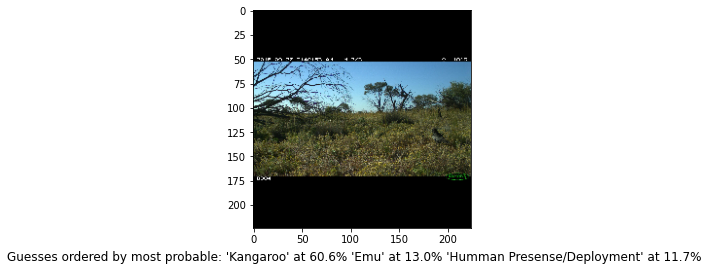

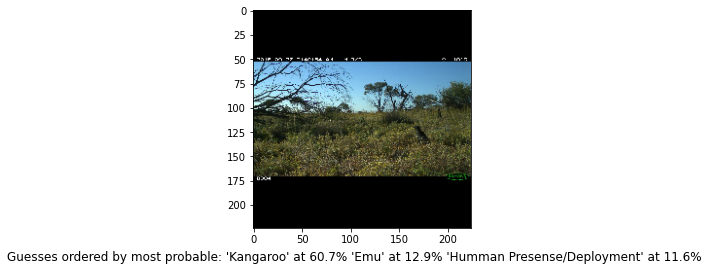

In [15]:
predictions_prob = model.predict(unlabelled_test_images)

for i in range(len(unlabelled_test_images)):    
    sorted_prob = np.sort(predictions_prob[i])
    max_pred = sorted_prob[len(sorted_prob) - 1]
    # find the index in the unsorted array, as that maps to an index in `class_mappings`
    max_pred_index = np.where(predictions_prob[i] == max_pred)[0][0]
    
    second_max_pred = sorted_prob[len(sorted_prob) - 2]
    second_max_pred_index = np.where(predictions_prob[i] == second_max_pred)[0][0]
    
    third_max_pred = sorted_prob[len(sorted_prob) - 3]
    third_max_pred_index = np.where(predictions_prob[i] == third_max_pred)[0][0]
    
    pred_str = "Guesses ordered by most probable: "
    pred_str += "'{}' at {}% ".format(class_mappings[max_pred_index], np.around(float(max_pred * 100), 1))
    pred_str += "'{}' at {}% ".format(class_mappings[second_max_pred_index], np.around(float(second_max_pred * 100), 1))
    pred_str += "'{}' at {}% ".format(class_mappings[third_max_pred_index], np.around(float(third_max_pred * 100), 1))
    
    displayImage(cv2.cvtColor(unlabelled_test_images[i], cv2.COLOR_BGR2RGB), pred_str)

## Save the model
* use the current date/time so we can keep incrementation progress of the model as we re-run it

In [ ]:
now = datetime.now()
dt_string = now.strftime('%d-%m-%Y_%H:%M:%S')
print("saving model as: 'ZFNet-{}.h5'.'".format(dt_string))

model.save('saved_models/ZFNet-{}.h5'.format(dt_string))

## Free up the GPU's memory

In [16]:
cuda.select_device(0)
cuda.close()